# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/General_Functions")

# Agulhas

## Import data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 146 ms, sys: 40.6 ms, total: 187 ms
Wall time: 186 ms


## Data/Parameters for dynamical system

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 10

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

CPU times: user 238 µs, sys: 68 µs, total: 306 µs
Wall time: 236 µs


<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
## Spatio-temporal domain of dynamical system

In [4]:
%%time
# Initial time (in days)
t0 = 25

# Final time (in days)
tN = 45

# time step-size
dt = .2

time = np.arange(t0, tN+dt, dt)

# longitudinal and latitudinal boundaries (in degrees)
xmin = 0
xmax = 5
ymin = -35
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.05
dy = 0.05

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

CPU times: user 328 µs, sys: 196 µs, total: 524 µs
Wall time: 343 µs


In [5]:
%%time
# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

CPU times: user 62.8 ms, sys: 10.3 ms, total: 73.1 ms
Wall time: 72.2 ms


## Velocity interpolation

In [6]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 180 ms, sys: 18.6 ms, total: 199 ms
Wall time: 197 ms


## Gradient of flow map

Trajectories are launched from the grid of initial conditions specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 14-17)**.

The temporal domain is specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 2-11)**.

In [7]:
%%time
# aux_grid = True --> Use auxiliary grid for numerical computation of gradient.
# Otherwise aux_grid = False.
aux_grid = True

grad_Fmap_grid = DS._grad_Fmap_grid(aux_grid)

  0%|          | 0/102 [00:00<?, ?it/s]

CPU times: user 4.38 s, sys: 2.19 s, total: 6.58 s
Wall time: 3min 18s


## Cauchy-Green strain tensor over meshgrid of initial conditions

In [8]:
%%time
B, C = DS._cauchy_green_strain(grad_Fmap_grid)

CPU times: user 62 ms, sys: 1.07 ms, total: 63.1 ms
Wall time: 61.9 ms


## Identify vortex centers from local maximum of LAVD

In order to define a poincare section from where to start the integration of the shearlines, we need to locate the vortex centers. Here, we use the fact that vortex centers are objectively identified as local maxima in the LAVD (Lagrangian Averaged Vorticity Deviation) field.

### Trajectory  computation

Trajectories are launched from the grid of initial conditions specified in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 14-17)**.
The temporal domain as well as the time resolution is also indicated in [Section 2.3](#Spatio-Temporal-Domain-of-Dynamical-System) **(Line 2-11)**.

In [9]:
trajectory_grid = DS._trajectory_grid()[0]

  0%|          | 0/102 [00:00<?, ?it/s]

### LAVD-field

The LAVD-field is computed from the trajectories defined over a meshgrid of initial conditions.

In [10]:
%%time
sys.path.append(parent_directory+"/Demos/LAVD")
from ipynb.fs.defs.LAVD import _LAVD

LAVD = _LAVD(trajectory_grid, DS, time)

  0%|          | 0/102 [00:00<?, ?it/s]

CPU times: user 8.61 s, sys: 4.31 s, total: 12.9 s
Wall time: 1min 46s


Centers of elliptic LCS are given by local maxima in the LAVD-field.

In [11]:
%%time
from ipynb.fs.defs.loc_max import _loc_max

# distance between local maxima
max_distance = 1

x_vortex, y_vortex, _ = _loc_max(max_distance, X_domain, Y_domain, LAVD)

  0%|          | 0/98 [00:00<?, ?it/s]

CPU times: user 168 ms, sys: 3.57 ms, total: 172 ms
Wall time: 169 ms


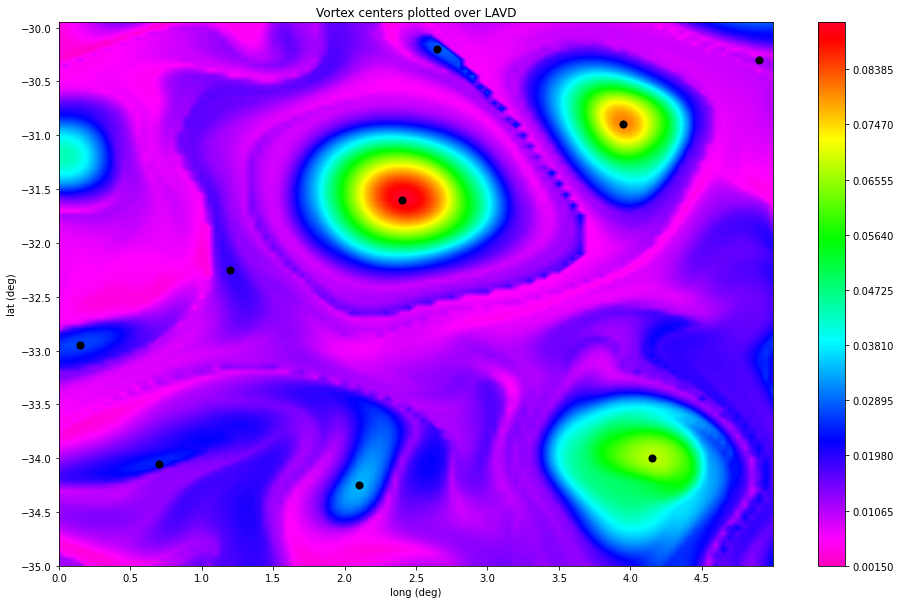

In [12]:
###################################### PLOT VORTEX CENTERS FROM LAVD ######################################
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

cax = ax.contourf(X_domain, Y_domain, LAVD, levels=600, cmap='gist_rainbow_r')
ax.scatter(x_vortex, y_vortex, s = 50, c = 'k', label='Vortex center')

ax.set_xlabel('long (deg)')
ax.set_ylabel('lat (deg)')

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), .5))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), .5))

ax.set_title('Vortex centers plotted over LAVD')

cbar = plt.colorbar(cax)
plt.show()

## Shearlines (Elliptic LCS)

Elliptic LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \sqrt{\dfrac{\lambda_2-\lambda^2}{\lambda_2-\lambda_1}}\xi_2(\mathbf{x}_0;t_0, t_1) \pm\sqrt{\dfrac{\lambda_1-\lambda^2}{\lambda_2-\lambda_1}}\xi_1(\mathbf{x}_0;t_0, t_1),
\label{eq: shearlines}
\end{equation}

with $ \xi_1, \xi_2 $ denoting the eigenvector associated to the weakest/strongest eigenvalue $ \lambda_1/\lambda_2 $ of $ C_{t_0}^{t_1}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The outermost closed shearline mark initial positions of elliptic LCS at time $ t_0 $. The integration of the autonomous system in eq. \ref{eq: shearlines} is done with respect to the non-dimensional parameter $ s $.

In [ ]:
%%time
from ipynb.fs.defs.shearlines import _shearlines
from ipynb.fs.defs.outermost_closed_shearline import _outermost_closed_shearline
import matplotlib.pyplot as plt

# step-size used for integration with respect to parameter 's'
step_size = 0.02

# range of lambda values
lambda_range = [1]#np.arange(.95, 1.05, 0.05)

# length Poincare-section 
len_poincare = 2

# threshold distance for re-intersection of closed shearline with poincare section
d_threshold = 0.025

# threshold length of vortex
length_threshold = 2*np.pi*len_poincare*2

# defined elliptic LCS
elliptic_LCS = [[], []]
lambda_elliptic_LCS = []

for i in range(len(x_vortex)):
    
    for lam in lambda_range:
        print("lambda: ", lam)
    
        # integrate lambda line for eta_pos and eta_neg
        for sign_eta in [-1, 1]:

            shearlines, distance_ps_s, vector_field = _shearlines(X_domain, Y_domain, C, lam, x_vortex[i], y_vortex[i], len_poincare, length_threshold, step_size, Incompressible, sign_eta)
            
            elliptic_LCS_x, elliptic_LCS_y = _outermost_closed_shearline(X_domain, Y_domain, C, lam, sign_eta, shearlines, distance_ps_s, x_vortex[i], y_vortex[i], d_threshold, length_threshold, step_size, Incompressible)
            
            if elliptic_LCS_x is not None:
                elliptic_LCS[0].append(elliptic_LCS_x)
                elliptic_LCS[1].append(elliptic_LCS_y)
                lambda_elliptic_LCS.append(lam)

2.4000000000000004
-31.600000000000193
lambda:  1


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

3.95
-30.900000000000233
lambda:  1


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
###################################### PLOT ELLIPTIC LCS ######################################

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

for i in range(len(elliptic_LCS[0])):
    
    ax.plot(elliptic_LCS[0][i], elliptic_LCS[1][i], c = 'k')#label=lambda_elliptic_LCS[i])

ax.set_xlabel('long (deg)')
ax.set_ylabel('lat (deg)')

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, .1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, .1))

ax.set_title('Elliptic LCSs from closed shearlines')

#plt.legend(loc="upper right")
plt.show()

## Shrinklines (Repelling LCS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shrinklines}
\end{equation}

with $ \xi_1 $ denoting the eigenvector associated to the weakest eigenvalue $ \lambda_1 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most repelling shrinklines mark initial positions of repelling LCSs. Repelling LCSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ \lambda_2(\mathbf{x}_0;t_0, t_N) $ among all neighbouring shrinklines.

In [ ]:
from ipynb.fs.defs.shrinklines import _shrinklines

# step-size used for integration with respect to parameter 's'
step_size = 0.02

# threshold distance to locate local maxima in the 'lambda_2' field of 'C'
max_distance = 0.02

# maximum length of shrinkline
max_length = 20

shrinklines = _shrinklines(X_domain, Y_domain, C, max_distance, max_length, step_size, Incompressible)

In [ ]:
###################################### PLOT REPELLING LCS ######################################

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
for i in range(len(shrinklines[0])):
    ax.plot(shrinklines[0][i], shrinklines[1][i], c = 'r')
    
ax.set_xlabel('x', fontsize = 16)
ax.set_ylabel('y', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, .1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, .1))

ax.set_title('Repelling LCSs from shrinklines', fontsize = 20)

plt.show()

## Stretchlines (Attracting LCS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \xi_2(\mathbf{x}_0;t_0, t_N),
\label{eq: stretchlines}
\end{equation}

with $ \xi_2 $ denoting the eigenvector associated to the strongest eigenvalue $ \lambda_2 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most attracting stretchlines mark initial positions of attracting LCSs. Attracting LCSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ \lambda_1(\mathbf{x}_0;t_0, t_N) $ among all neighbouring stretchlines.

In [ ]:
from ipynb.fs.defs.stretchlines import _stretchlines

# step-size used for integration with respect to parameter 's'
step_size = 0.01

# threshold distance to locate local minima in the 'lambda_1' field of 'C'
max_distance = 0.02

# maximum length of stretchline
max_length = 20

stretchlines = _stretchlines(X_domain, Y_domain, C, max_distance, max_length, step_size, Incompressible)

In [ ]:
###################################### PLOT ATTRACTING LCS ######################################

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()
for i in range(len(stretchlines[0])):
    ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'g')
    
ax.set_xlabel('x', fontsize = 16)
ax.set_ylabel('y', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, .1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, .1))

ax.set_title('Attracting LCSs from stretchlines', fontsize = 20)

plt.show()